In [7]:
# load data from wheel encoders and lidar (just wheel encoders for now)
import numpy as np
import pickle
from scipy import io
import pdb

class Robot:
    def __init__(self):
        # Physical data on robot
        self.wheel_diameter =.254 
        self.axle_width = .47265
        # Wheel encoder data
        self.wheel_encoder_FR = None
        self.wheel_encoder_FL = None
        self.wheel_encoder_RR = None
        self.wheel_encoder_RL = None
        self.wheel_encoder_ts = None
        self.last_we_reading = None
        
        #Lidar data
        self.lidar = None
    
        # Trajectory data
        self.current_pose = np.array([0.0, 0.0, 0.0])
        self.prev_delta = np.array([0.0, 0.0]) # Encodes displacement and theta
    
    
    def get_encoder(self, file_name):

        data = io.loadmat(file_name+".mat")
    #	pdb.set_trace()

        
        
        self.wheel_encoder_FR = np.double(data['Encoders']['counts'][0,0][0])
        self.wheel_encoder_FL = np.double(data['Encoders']['counts'][0,0][1])
        self.wheel_encoder_RR = np.double(data['Encoders']['counts'][0,0][2])
        self.wheel_encoder_RL = np.double(data['Encoders']['counts'][0,0][3])
        self.wheel_encoder_ts = np.double(data['Encoders']['ts'][0,0][0])
        self.last_we_reading = -1

    
    def get_lidar(self, file_name):
        data = io.loadmat(file_name+".mat")
        lidar = []
        angles = np.double(data['Hokuyo0']['angles'][0][0])
        ranges = np.array(data['Hokuyo0']['ranges'][0][0]).T
        ts_set = data['Hokuyo0']['ts'][0,0][0]

        idx = 0	
        for m in ranges:
            tmp = {}
            tmp['t'] = ts_set[idx]
            tmp['scan'] = m
            tmp['angle'] = angles
            lidar.append(tmp)
            idx = idx + 1
        self.lidar = lidar
        return lidar
    
    
    def deadReckoning(self, ts):
        '''
        Get dead reckoning of wheel odometry at time stamp ts
        
        input: ts
        '''
        
        tick_length = (1.0 / 360.0) * np.pi * self.wheel_diameter
        x_prev = self.current_pose[0]
        y_prev = self.current_pose[1]
        theta_prev = self.current_pose[2]
        
        print(np.absolute(self.wheel_encoder_ts - ts)[1000:1500])
        closest_we_reading = np.argmin(np.absolute(self.wheel_encoder_ts - ts))
        if closest_we_reading == self.wheel_encoder_ts.shape[0] - 1:
          closest_we_reading -= 1
        if closest_we_reading < self.last_we_reading:
          print("ERROR: Provided time step is less than previous...")
          sys.exit(1)
        
        
        # Sum of readings over a period of time encoders spit out the number of readings PER time step
        rl = np.sum(self.wheel_encoder_RL[closest_we_reading : ts + 1])
        rr = np.sum(self.wheel_encoder_RL[closest_we_reading : ts + 1])
        
        sl = rl * tick_length
        sr = rr * tick_length
        
        s = (sl + sr) / 2
        
        self.prev_delta[0] = s
        self.prev_delta[1] = s / (1.5 * self.axle_width)
        
        self.current_pose[2] = theta_prev + self.prev_delta[1]
        self.current_pose[0] = x_prev + s * np.cos(self.current_pose[2])
        self.current_pose[1] = y_prev + s * np.sin(self.current_pose[2])
        
        # reset the last wheel encoder reading for the next iteration
#         print(self.last_we_reading)
        print(closest_we_reading)
        
        self.last_we_reading = closest_we_reading
        
        return np.array(self.prev_delta)
        
        
# robot = Robot()
# robot.get_encoder('data/Encoders23')
# # acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, imu_ts	 = ld.get_imu('imuRaw20')

# FR, FL, RR, RL,enc_ts = ld.get_encoder('Encoders20')

# lidar = ld.get_lidar('Hokuyo20')


# robot.deadReckoning(500)


In [26]:
# Understand data
robot = Robot()
robot.get_lidar('data/Hokuyo20')
robot.get_encoder('data/Encoders20')
print(robot.lidar[0]) # LIDAR data comes in dictionary. Each time stamp represents TOF readings along with the angle they are captured at
print(robot.wheel_encoder_ts[0]) # Odometry data represents how far wheel moved at each time step
      

{'t': 1298445274.550587, 'scan': array([3.375     , 3.375     , 3.38199997, ..., 4.90999985, 4.90999985,
       4.90999985]), 'angle': array([[-2.35619449],
       [-2.35183117],
       [-2.34746784],
       ...,
       [ 2.34746784],
       [ 2.35183117],
       [ 2.35619449]])}
1298445274.541885


In [27]:
print("ehhlo")

ehhlo


In [ ]:
    
    
    def get_imu(self, file_name):

        data = io.loadmat(file_name+".mat")

        acc_x = np.double(data['vals'])[0]
        acc_y = np.double(data['vals'])[1]
        acc_z = np.double(data['vals'])[2]
        gyro_x = np.double(data['vals'])[3]
        gyro_y = np.double(data['vals'])[4]
        gyro_z = np.double(data['vals'])[5]	
        ts = np.double(data['ts'][0])
    #	pdb.set_trace()

        return acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, ts	 

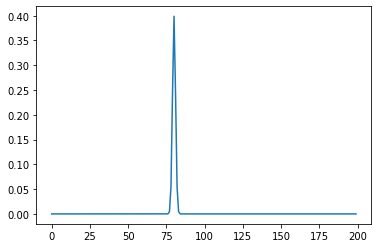

In [36]:
# Pseduocode for particle filter. Start out with some fake data. This is for unit testing

import numpy as np
# import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt


class Particle:
    '''
    Separated by [state, weight] per particle
    
    Should I keep them in a single one, or watch the group of particles?
    
    I decided to go with a single particle. Then if I want I can remove it
    
    '''
    def __init__(self, state):
        self.state = state
#         self.number = number
#         self.weight = weight
        self.weight = np.random.uniform()
#     self.particles = list(np.random.uniform(size = number))
        
    def display_weight(self):
        print(self.weight)
    
    def display_state(self):
        print(self.state)
        
    def replace(state, weight):
        self.state = state
        self.weight = weight

        
x = np.arange(-50,150)

norm = st.norm.pdf(x, loc = 30)
# print(norm[-10:])





In [ ]:
dir(st)

# Acceptance rejection sampling

Goal is to estimate a hard distribution to model analytically. This is done based on a ratio, which uses relative height, using a uniform distribution as a modeler, to figure out the ratio to sample from


![](https://wiseodd.github.io/img/2015-10-21-rejection-sampling/01.png)
## After scaling
![](https://wiseodd.github.io/img/2015-10-21-rejection-sampling/02.png)

Disadvantage is that you may have to go through many samples get a high resolution distribution

U [0.6957096  0.14503001 0.83719764 0.50403038 0.31585401 0.14713075
 0.64304237 0.85647485 0.45608325 0.09642327]
X [7 2 9 6 4 2 7 9 5 1]
[0.11 0.01 0.08 0.12 0.1  0.09 0.1  0.1  0.1  0.19]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
550


(array([62.,  4., 54., 68., 62., 42., 43., 56., 61., 98.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

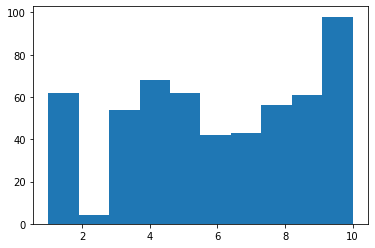

In [16]:
# Acceptance-rejection sampling

import numpy as np
from scipy.stats import uniform

# This is the target distribution. You want to create samples baesd upon that
Y = np.arange(1, 11)
p = np.array([0.11, 0.01, 0.08, 0.12, 0.10, 0.09, 0.10, 0.10, .10, .19])

# This is the proposed distribution which is much easier to model - a uniform distribution
q  = np.full(p.shape, 1/10)

# Scaling factor, used to get the maximal height seen in distribution (this gets rid of the normalization in the distribution)
c = np.max(p / q)

# Will hold the value of simulated distribution
samples = []

# Number of samples that will be tested
iter = 1000

# If I get a high uniform value, then X (proposal) is also going to be really high. So it is less likely that these values will be chosen

U = uniform.rvs(size = iter)
X = np.array(10 * U + 1, dtype = "int")

for i in range(iter):
    if np.random.uniform() < (p[X[i] -1 ]) / (c * q[X[i] - 1]):
        samples.append(X[i])

import matplotlib.pyplot as plt
plt.hist(np.array(samples))